## Import modules:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline

#display parent directory and working directory
#print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
#print(os.getcwd()+':', os.listdir(os.getcwd()));

Using TensorFlow backend.


## Explore the data:

In [2]:
## load and check data -training

dataFiles = {'train': './data/train.csv', 'test': './data/test.csv'}
dataFrame = {}
for key in ['train','test']:
    if os.path.isfile(dataFiles[key]):
        dataFrame[key] = pd.read_csv(dataFiles[key])
        print(key + ' file loaded: data_df({0[0]},{0[1]})'.format(dataFrame[key].shape))
    else:
        print('Error: train.csv not found')
    
    # basic info about data
    print('')
    print(dataFrame[key].info())
    
    # no missing values
    print('')
    print(dataFrame[key].isnull().any().describe())
    
    if 'label' in dataFrame[key].columns:
        # 10 different labels ranging from 0 to 9
        print('')
        print('distinct labels ', np.sort(dataFrame[key]['label'].unique()))
        
        # data are approximately balanced (less often occurs 5, most often 1)
        print('')
        print(dataFrame[key]['label'].value_counts())

    print('')
    print('------------')
    print('')

train file loaded: data_df(42000,785)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None

count       785
unique        1
top       False
freq        785
dtype: object

distinct labels  [0 1 2 3 4 5 6 7 8 9]

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

------------

test file loaded: data_df(28000,784)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None

count       784
unique        1
top       False
freq        784
dtype: object

------------



## Some functions to...
 - Normalize data
 - Tramslate labels to one-hot vectors and vice-versa
 - Compute accuracy of predictions

In [3]:
def normalize_data(data): 
    data = data / data.max() # convert from [0:255] to [0.:1.]
    return data

# convert class labels from scalars to one-hot vectors e.g. 1 => [0 1 0 0 0 0 0 0 0 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# convert one-hot encodings into labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

# computet the accuracy of label predictions
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

# computet the accuracy of one-hot encoded predictions
def accuracy_from_one_hot_labels(y_target, y_pred):
    y_target = one_hot_to_dense(y_target).reshape(-1,)
    y_pred = one_hot_to_dense(y_pred).reshape(-1,)
    return np.mean(y_target == y_pred)


In [4]:
#Dataframe with labels:
dataFrame['train'].iloc[:,:]

#Dataframe without labels:
dataFrame['train'].iloc[:,1:]

#Dataframe values --nparray of shape...:
dataFrame['train'].iloc[:,1:].values.shape

dataFrame['train'].iloc[:,1:].values.reshape(-1,28,28,1).shape

(42000, 28, 28, 1)

## Build the x (data) and y (labels) vectors for training

x_train_valid.shape =  (42000, 28, 28, 1)
y_train_valid_labels.shape =  (42000,)
y_train_valid.shape =  (42000, 10)
image_size =  784
image_width =  28
image_height =  28
labels_count =  10


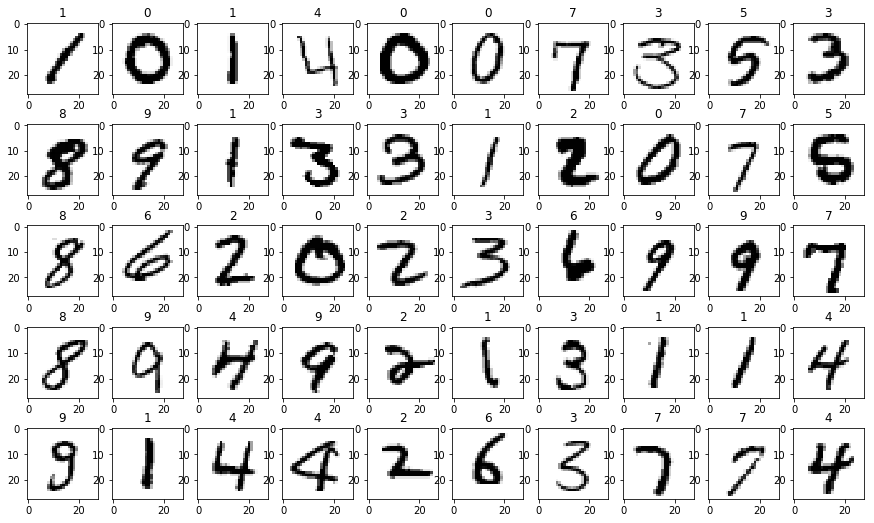

In [5]:
# extract and normalize images
image_size = 784
image_width = image_height = 28
x_train_valid = dataFrame['train'].iloc[:,1:].values.reshape(-1,image_height,image_width,1) # (42000,28,28,1) array
x_train_valid = x_train_valid.astype(np.float) # convert from int64 to float32
x_train_valid = normalize_data(x_train_valid)

# extract image labels
y_train_valid_labels = dataFrame['train'].iloc[:,0].values # (42000,1) array
labels_count = np.unique(y_train_valid_labels).shape[0]; # number of different labels = 10

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(y_train_valid_labels[i])
    plt.imshow(x_train_valid[i].reshape(28,28), cmap=cm.binary)
    
# labels in one hot representation
y_train_valid = dense_to_one_hot(y_train_valid_labels, labels_count).astype(np.uint8)


print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid_labels.shape = ', y_train_valid_labels.shape)
print('y_train_valid.shape = ', y_train_valid.shape)
print('image_size = ', image_size )
print('image_width = ', image_width)
print('image_height = ', image_height)
print('labels_count = ', labels_count)

## Data augmentation

In [6]:
# generate new images via rotations, translations, zoom using keras
def generate_images(imgs):
    
    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
  
    return imgs[0]

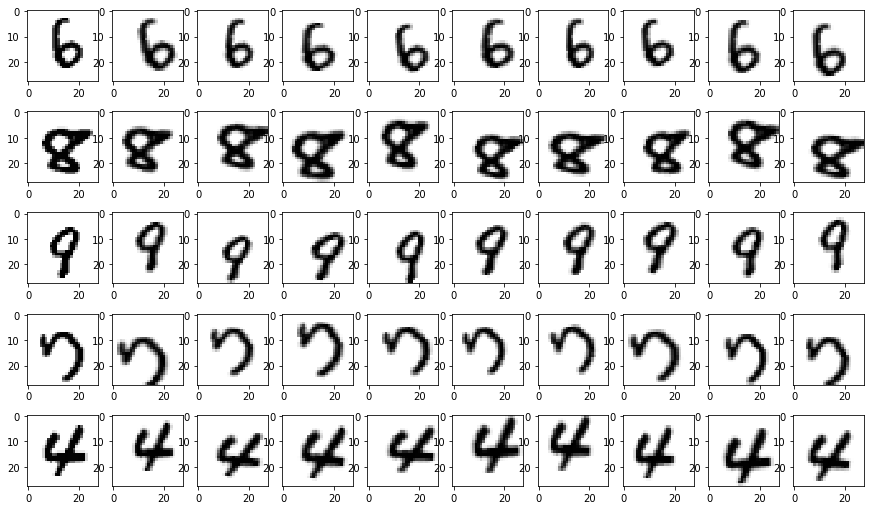

In [7]:
#Test how the image generation is doing...
fig,axs = plt.subplots(5,10, figsize=(15,9))
for i in range(5):
    n = np.random.randint(0,x_train_valid.shape[0]-2)
    axs[i,0].imshow(x_train_valid[n:n+1].reshape(28,28),cmap=cm.binary)
    axs[i,1].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,2].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,3].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,4].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,5].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,6].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,7].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,8].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,9].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)


## Different models with scikit-learn:

 - **Logistic Regression**:  
Example: Probability of passing an exam versus hours of study
Suppose we wish to answer the following question:
A group of 20 students spend between 0 and 6 hours studying for an exam. How does the number of hours spent studying affect the probability that the student will pass the exam? The reason for using logistic regression for this problem is that the values of the dependent variable, pass and fail, while represented by "1" and "0", are not cardinal numbers. If the problem was changed so that pass/fail was replaced with the grade 0–100 (cardinal numbers), then simple regression analysis could be used. 
     
 - **Decission Tree**:  
The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. For instance, decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

 - **Random Forest**
Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance. This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance in the final model. In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets, i.e. have low bias, but very high variance. 

 - **Extra Trees**:  
Fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The Extra-Tree method (standing for **extremely randomized trees**) was proposed with the main objective of further randomizing tree building in the context of numerical input features, where the choice of the optimal cut-point is responsible for a large proportion of the variance of the induced tree.

 - **Gradient Boost**
 [https://en.wikipedia.org/wiki/Gradient_boosting#Informal_introduction] 

 - **Naive Bayes**
Naive Bayes has been studied extensively since the 1950s. It remains a popular (baseline) method for text categorization: the problem of judging documents as belonging to one category or the other (such as spam or legitimate, sports or politics, etc.) with word frequencies as the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers. 

In [8]:
##Try out some basic sklearn models

logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs',
                                                 multi_class='multinomial')
decision_tree = sklearn.tree.DecisionTreeClassifier()
random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0)
extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0)
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose=0)
gaussianNB = sklearn.naive_bayes.GaussianNB()

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

# Print the training and validation folds indices:
for i, (train_index, valid_index) in enumerate((kfold.split(x_train_valid))):
    print(i,'|||',train_index,train_index.shape,'|||',valid_index,valid_index.shape)


0 ||| [    0     2     3 ... 41996 41997 41998] (37800,) ||| [    1    19    20 ... 41987 41994 41999] (4200,)
1 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [   27    49    64 ... 41976 41984 41993] (4200,)
2 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [   15    30    57 ... 41983 41988 41995] (4200,)
3 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [    8    12    21 ... 41935 41941 41961] (4200,)
4 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [   38    66    68 ... 41956 41959 41968] (4200,)
5 ||| [    0     1     2 ... 41996 41997 41999] (37800,) ||| [    9    14    16 ... 41991 41992 41998] (4200,)
6 ||| [    0     1     4 ... 41997 41998 41999] (37800,) ||| [    2     3     5 ... 41977 41981 41986] (4200,)
7 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [    6    11    28 ... 41963 41971 41990] (4200,)
8 ||| [    1     2     3 ... 41997 41998 41999] (37800,) ||| [    0     4    35 ... 41972 41974 41985] (4200,)
9

In [9]:
# store models in dictionary
base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               'gradient_boost': gradient_boost, 'random_forest': random_forest, 
               'decision_tree': decision_tree, 'gaussianNB': gaussianNB}

# choose models for out-of-folds predictions
#take_models = ['logreg','decision_tree','random_forest','extra_trees','gaussianNB']
take_models = ['extra_trees']

# dictionaries for saving results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}


for mn in take_models:
    train_acc[mn] = []
    valid_acc[mn] = []



# start timer
start = datetime.datetime.now();
for i,(train_indices_list, valid_indices_list) in enumerate(kfold.split(x_train_valid)):

    # train and validation data of original images
    x_train = x_train_valid[train_indices_list].reshape(-1,784) #originaly it was (many,28,28,1)
    y_train = y_train_valid[train_indices_list] # it is (many,10) --one hot encoded
    x_valid = x_train_valid[valid_indices_list].reshape(-1,784)
    y_valid = y_train_valid[valid_indices_list]

    for mn in take_models:

        # create cloned model from base models
        model = sklearn.base.clone(base_models[mn])
        model.fit(x_train, one_hot_to_dense(y_train))

        # predictions
        y_train_pred[mn] = model.predict_proba(x_train)
        y_valid_pred[mn] = model.predict_proba(x_valid)
        train_acc[mn].append(accuracy_from_one_hot_labels(y_train_pred[mn], y_train))
        valid_acc[mn].append(accuracy_from_one_hot_labels(y_valid_pred[mn], y_valid))

        print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[mn][-1], 
                                                             valid_acc[mn][-1]))
    # only one iteration
    if False:
        break;
        
for mn in take_models:
    print(mn+': averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                        np.mean(valid_acc[mn])))

0 : extra_trees train/valid accuracy = 1.000/0.945
1 : extra_trees train/valid accuracy = 1.000/0.946
2 : extra_trees train/valid accuracy = 1.000/0.946
3 : extra_trees train/valid accuracy = 1.000/0.945
4 : extra_trees train/valid accuracy = 1.000/0.942
5 : extra_trees train/valid accuracy = 1.000/0.945
6 : extra_trees train/valid accuracy = 1.000/0.943
7 : extra_trees train/valid accuracy = 1.000/0.938
8 : extra_trees train/valid accuracy = 1.000/0.948
9 : extra_trees train/valid accuracy = 1.000/0.941
extra_trees: averaged train/valid accuracy = 1.000/0.944


extra_trees averaged train/valid accuracy = 1.000/0.944


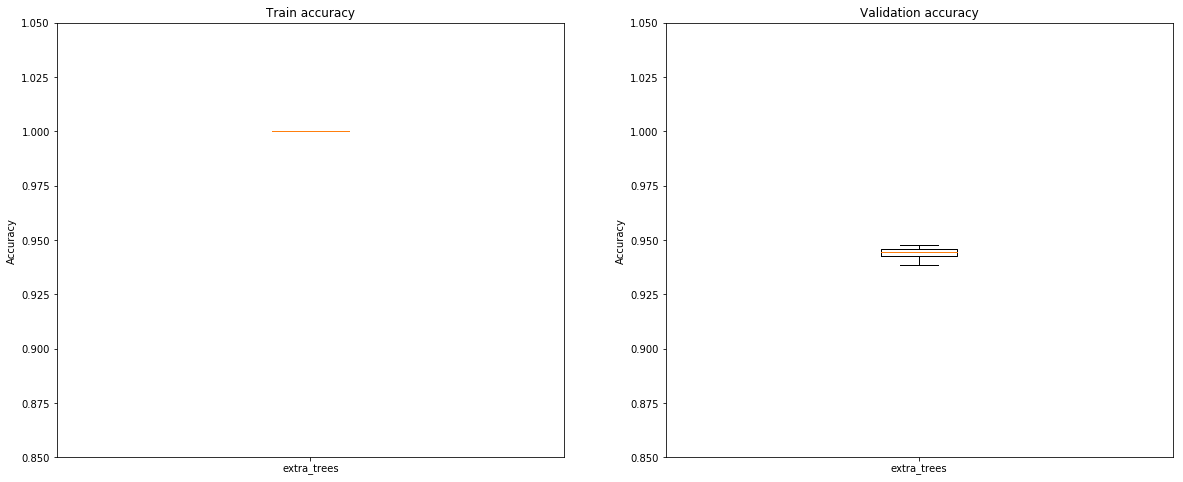

In [10]:
## compare accuracies of base models

# boxplot algorithm comparison
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
plt.title('Train accuracy')
plt.boxplot([train_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');
ax.set_ylim([0.85,1.05])

ax = fig.add_subplot(1,2,2)
plt.title('Validation accuracy')
plt.boxplot([valid_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');
ax.set_ylim([0.85,1.05])

for mn in train_acc.keys():
    print(mn + ' averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                             np.mean(valid_acc[mn])))

In [11]:
#[train_acc[mn] for mn in train_acc.keys()]

In [12]:
x_train_valid[[1,2,3,4,5,6,7,8,9,0]].shape#reshape(-1,784).shape

(10, 28, 28, 1)

In [13]:
y_train_valid[[1,2,3,4,5,8,9,0]].shape

(8, 10)

In [14]:
#for i in range(100):
#    print(one_hot_to_dense(y_train[i].reshape(1,-1)), one_hot_to_dense(y_train_pred['logreg'][i].reshape(1,-1)))

## Use the best model and predict the test dataset

In [15]:
#We will need to train it again:
model_to_use = sklearn.ensemble.ExtraTreesClassifier(verbose=0)
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

# Print the training and validation folds indices:
for i, (train_index, valid_index) in enumerate((kfold.split(x_train_valid))):
    print(i,'|||',train_index,train_index.shape,'|||',valid_index,valid_index.shape)

#Accuracies of train and validation sets (folds):
train_acc = []
valid_acc = []

#We iterate several times just to be sure, although it should be enough with a single time:
for i,(train_indices_list, valid_indices_list) in enumerate(kfold.split(x_train_valid)):

    # train and validation data of original images
    x_train = x_train_valid[train_indices_list].reshape(-1,784) #originaly it was (many,28,28,1)
    y_train = y_train_valid[train_indices_list] # it is (many,10) --one hot encoded
    x_valid = x_train_valid[valid_indices_list].reshape(-1,784)
    y_valid = y_train_valid[valid_indices_list]

    # fit the model
    model = sklearn.base.clone(base_models['extra_trees'])
    model.fit(x_train, one_hot_to_dense(y_train))
    
    # predictions and accuracy
    y_train_pred = model.predict_proba(x_train)
    y_valid_pred = model.predict_proba(x_valid)
    train_acc.append(accuracy_from_one_hot_labels(y_train_pred, y_train))
    valid_acc.append(accuracy_from_one_hot_labels(y_valid_pred, y_valid))

    print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[-1], 
                                                             valid_acc[-1]))
        
#Print average
print('Averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc),
                                                        np.mean(valid_acc)))

0 ||| [    0     2     3 ... 41996 41997 41998] (37800,) ||| [    1    19    20 ... 41987 41994 41999] (4200,)
1 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [   27    49    64 ... 41976 41984 41993] (4200,)
2 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [   15    30    57 ... 41983 41988 41995] (4200,)
3 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [    8    12    21 ... 41935 41941 41961] (4200,)
4 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [   38    66    68 ... 41956 41959 41968] (4200,)
5 ||| [    0     1     2 ... 41996 41997 41999] (37800,) ||| [    9    14    16 ... 41991 41992 41998] (4200,)
6 ||| [    0     1     4 ... 41997 41998 41999] (37800,) ||| [    2     3     5 ... 41977 41981 41986] (4200,)
7 ||| [    0     1     2 ... 41997 41998 41999] (37800,) ||| [    6    11    28 ... 41963 41971 41990] (4200,)
8 ||| [    1     2     3 ... 41997 41998 41999] (37800,) ||| [    0     4    35 ... 41972 41974 41985] (4200,)
9

In [16]:
x_test = dataFrame['test'].iloc[:,:].values.reshape(-1,image_height,image_width,1) # (42000,28,28,1) array
x_test = x_test.astype(np.float) # convert from int64 to float32
x_test = normalize_data(x_test)
x_test = x_test[:].reshape(-1,784)
y_test_predict = model.predict(x_test)
y_test_predict_prob = model.predict_proba(x_test)

In [17]:
y_test_predict

array([2, 0, 9, ..., 3, 9, 2])

In [18]:
y_test_predict == one_hot_to_dense(y_test_predict_prob)

array([ True,  True,  True, ...,  True,  True,  True])

## Check the predictions by eye

x_test.shape =  (28000, 784)
y_predicted_labels.shape =  (28000,)


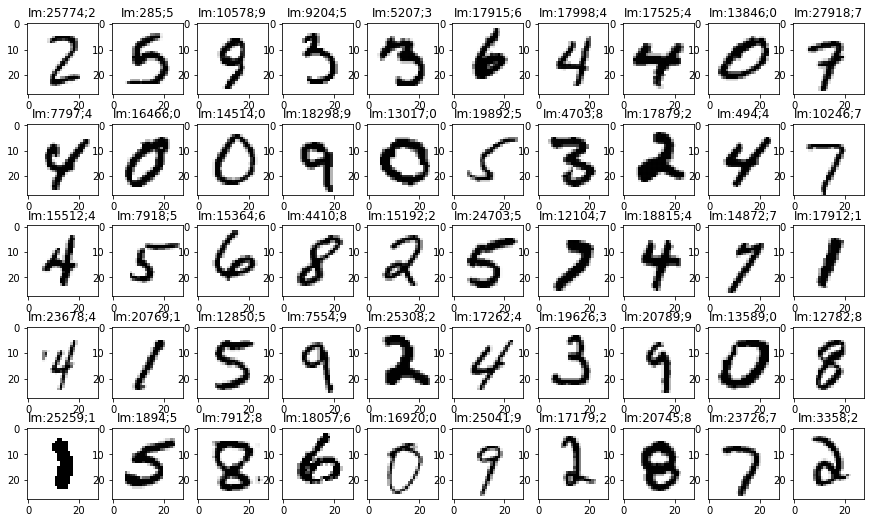

In [19]:
image_size = 784
image_width = image_height = 28

# extract image labels
y_predicted_labels = y_test_predict # (42000,1) array

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    n = np.random.randint(0,x_test.shape[0])
    plt.subplot(5,10,1+i)
    plt.title("Im:" + str(n+1) + ";" + str(y_predicted_labels[n]))
    plt.imshow(x_test[n].reshape(image_height,image_width), cmap=cm.binary)
    
print('x_test.shape = ', x_test.shape)
print('y_predicted_labels.shape = ', y_predicted_labels.shape)

## Write Submision File

In [20]:
#plot some images and labels
with open("./sciKitExtraTreesPredictions.csv",'w') as fw:
    for i in range(x_test.shape[0]):
        fw.write(str(i+1) + "," + str(y_predicted_labels[i]) + '\n');